Sources:
- RNN Simple example: https://medium.com/@praveenraj.gowd/understanding-recurrent-neural-networks-rnn-nlp-e2f4cae03a4f
- Vanishing/exploding gradient theory: https://mmuratarat.github.io/2019-02-07/bptt-of-rnn

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Introduction to Recurrent Neural Networks

In this section I present the formulas and develop two simple models with the aim to explain the backward and forward pass in recurrent neural networks (vanilla RNN) and the calculations performed by the PyTorch `nn.RNN` module. An example of training a repetitive sequence like the $\sin(x)$ function is performed with each model. 

### Forward Pass Equations

For the forward pass in the RNN, the key equations are:

1. **Hidden State Update** at time step $ t $:
   $$
   h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
   $$
   
2. **Output** at time step $ t $:
   $$
   o_t = W_{hy} \cdot h_t + b_y
   $$
   $$
   \hat{y_t} = \text{softmax}(o_t)
   $$

Where:
- $x_{t}$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances
- $h_{t-1}$ is an $m \times n_{neurons}$ matrix containing the hidden state of the previous time-step for all instances
- $W_{xh}$ is an $n_{inputs} \times n_{neurons}$ matrix containing the connection weights between input and the hidden layer
- $W_{hh}$ is an $n_{neurons} \times n_{neurons}$ matrix containing the connection weights between two hidden layers
- $W_{yh}$ is an $n_{neurons} \times n_{outputs}$ matrix containing the connection weights between the hidden layer of the output
- $b_{h}$ is a vector of size $n_{neurons}$ containing each neuron's bias term
- $b_{y}$ is a vector of size $n_{neurons}$ containing each output's bias term
- $y_{t}$ is a vector of size $n_{neurons}$ containing the target vector

### Backward Pass Equations (Gradients)

For the backward pass, for this example could be the use the chain rule to compute gradients with respect to the loss $ \mathcal{L} $. Let’s define the loss function as mean squared error (MSE):
$$
\mathcal{L} = \frac{1}{T} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
$$
where $ y_t $ is the predicted output, and $ \hat{y}_t $ is the target output.

To compute the gradients, we follow these steps:

1. **Gradient of Loss with respect to the Output $ y_t $**:
   $$
   \frac{\partial \mathcal{L}}{\partial y_t} = \frac{2}{T}(y_t - \hat{y}_t)
   $$

2. **Gradient of Loss with respect to $ W_{hy} $**:
   $$
   \frac{\partial \mathcal{L}}{\partial W_{hy}} = \sum_{t=1}^{T} \frac{\partial \mathcal{L}}{\partial y_t} \cdot h_t^T
   $$

3. **Gradient of Loss with respect to $ b_y $**:
   $$
   \frac{\partial \mathcal{L}}{\partial b_y} = \sum_{t=1}^{T} \frac{\partial \mathcal{L}}{\partial y_t}
   $$

4. **Gradient of Loss with respect to the Hidden State $ h_t $**:
   $$
   \frac{\partial \mathcal{L}}{\partial h_t} = \frac{\partial \mathcal{L}}{\partial y_t} \cdot W_{hy}^T
   $$

5. **Gradient of Loss with respect to $ W_{xh} $**:
   $$
   \frac{\partial \mathcal{L}}{\partial W_{xh}} = \sum_{t=1}^{T} \left( \frac{\partial \mathcal{L}}{\partial h_t} \cdot (1 - h_t^2) \right) \cdot x_t^T
   $$
   where $ (1 - h_t^2) $ is the derivative of the $\tanh$ activation function.

6. **Gradient of Loss with respect to $ W_{hh} $**:
   $$
   \frac{\partial \mathcal{L}}{\partial W_{hh}} = \sum_{t=1}^{T} \left( \frac{\partial \mathcal{L}}{\partial h_t} \cdot (1 - h_t^2) \right) \cdot h_{t-1}^T
   $$

7. **Gradient of Loss with respect to $ b_h $**:
   $$
   \frac{\partial \mathcal{L}}{\partial b_h} = \sum_{t=1}^{T} \left( \frac{\partial \mathcal{L}}{\partial h_t} \cdot (1 - h_t^2) \right)
   $$

Based on the forward and backward equations the next code perform the forward and backward pass in vanilla RNNs using pytorch tensors.

In [3]:
# reproducibility 
torch.manual_seed(101)

# define the input sequence length, hidden size, and input size
seq_length = 5 # time steps
input_size = 3 # input feature size
hidden_size = 5 # hidden state size 
output_size = 2 # output size

# create random inputs 
x = torch.randn(seq_length, input_size, requires_grad=True)

# initialize weights and biases for the RNN with requires_grad=True
W_xh = torch.randn(input_size, hidden_size, requires_grad=True) #weights for input to hidden
W_hh = torch.randn(hidden_size, hidden_size, requires_grad=True) #weights for hidden to hidden
b_h = torch.randn(hidden_size, requires_grad=True) #bias for hidden state

# initialize weights and biases for the output layer
W_hy = torch.randn(hidden_size, output_size, requires_grad=True) #weights for hidden to output
b_y = torch.randn(output_size, requires_grad=True) # Bias for output

# initialize the hidden state
h_t = torch.zeros(hidden_size, requires_grad=True)

# forward pass through time (RNN loop)
outputs = []
for t in range(seq_length):
    x_t = x[t] # input at time step t
    h_t = torch.tanh(x_t @ W_xh + h_t @ W_hh + b_h) # raw output at time step t
    o_t = h_t @ W_hy + b_y # raw output at time step t
    y_hat_t = F.softmax(o_t, dim=0) # appy softmax to get prob distribution (no needed for regression task)
    outputs.append(y_hat_t)
    
# convert list of outputs to tensor (for further loss calculation)
outputs = torch.stack(outputs)

# define a dummy target (same shape as output for the loss)
target = torch.randn(seq_length, output_size)

# compute the loss (mean squared error)
loss = torch.mean((outputs - target) ** 2)

# backward pass (compute gradients)
loss.backward()

# Display gradients for each of the parameters
print("Gradients for W_xh:\n", W_xh.grad)
print("Gradients for W_hh:\n", W_hh.grad)
print("Gradients for b_h:\n", b_h.grad)
print("Gradients for W_hy:\n", W_hy.grad)
print("Gradients for b_y:\n", b_y.grad)

Gradients for W_xh:
 tensor([[-7.8188e-05,  1.1695e-02,  7.3847e-04,  1.8632e-02,  2.5207e-02],
        [-4.5986e-04, -2.8720e-02,  4.8346e-03, -2.3668e-03,  1.9975e-02],
        [-8.0011e-04,  9.6125e-03, -2.2699e-04,  1.5241e-03,  7.1645e-03]])
Gradients for W_hh:
 tensor([[-1.4970e-03, -1.7408e-02,  1.4480e-03,  8.5301e-03, -1.1939e-03],
        [-9.1581e-05, -1.7303e-02,  1.9248e-03, -4.3902e-03,  1.8475e-03],
        [ 5.6654e-04, -1.5212e-02,  1.1531e-03,  3.4608e-03, -1.1985e-03],
        [ 1.4973e-03, -1.7558e-02,  1.9408e-03, -9.1659e-03,  2.1590e-03],
        [-1.4363e-03,  8.9603e-03, -5.4360e-04, -6.3718e-04,  1.0863e-03]])
Gradients for b_h:
 tensor([ 0.0013,  0.0165, -0.0035, -0.0091, -0.0209])
Gradients for W_hy:
 tensor([[ 0.0416, -0.0416],
        [ 0.0461, -0.0461],
        [ 0.0549, -0.0549],
        [ 0.0540, -0.0540],
        [-0.0592,  0.0592]])
Gradients for b_y:
 tensor([-0.0421,  0.0421])


## Example 1
In this example a regression learning task is developed using a manual RNN and the PyTorch `nn.Module` with the goal of predicting a part of the $\sin(x)$ function.

### Creating the dataset
The tensor X represents a series of input sequences. Each sequence in X is a window of `seq_lenth` consecutive sine wave values.
The tensor Y represents the next value that follows each sequence in X.

By using sequences as input, we're teaching the RNN to understand the pattern and context of the sine wave over time. This approach allows the model to potentially capture more complex patterns than just learning a static function.

The `create_dataset` function creates these overlapping sequences from the original sine wave data.
Each $X[i]$ is a sequence of `seq_lenth` values, and the corresponding Y[i] is the `seq_lenth + 1` value.

PyTorch's RNN layers expect an input with the shape $[\text{batch_size}, \text{sequence_length}, \text{input_size)}]$

In [6]:
# Set random seed for reproducibility
torch.manual_seed(101)

# Parameters
seq_length = 50  # Length of input sequence (those are the number of "time steps")
input_size = 1   # Since we're predicting sine values, one feature
hidden_size = 10 # Size of hidden layer
output_size = 1  # Predicting a single value (sine wave)

# Generate sine wave data
x = np.linspace(0, 100, 1000)
y = np.sin(x)

# Prepare dataset
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + seq_length])
    return np.array(X), np.array(Y)

X, Y = create_dataset(y, seq_length)

# reshaping for pytorch rnn layer
X = torch.tensor(X, dtype=torch.float32).view(-1, seq_length, input_size)

# one predicted value for each input sequence
Y = torch.tensor(Y, dtype=torch.float32).view(-1, output_size)

### Manual model definition

In [7]:
# Manual RNN
class ManualRNN:
    def __init__(self):
        # Initialize weights and biases
        self.W_xh = torch.randn(input_size, hidden_size, requires_grad=True)  # weights for input to hidden
        self.W_hh = torch.randn(hidden_size, hidden_size, requires_grad=True)  # weights for hidden to hidden
        self.b_h = torch.randn(hidden_size, requires_grad=True)  # bias for hidden state
        self.W_hy = torch.randn(hidden_size, output_size, requires_grad=True)  # weights for hidden to output
        self.b_y = torch.randn(output_size, requires_grad=True)  # bias for output
    
    def forward(self, x):
        h_t = torch.zeros(hidden_size)  # Initialize hidden state
        outputs = []
        for t in range(seq_length):
            x_t = x[t]  # Input at time step t
            h_t = torch.tanh(x_t @ self.W_xh + h_t @ self.W_hh + self.b_h)  # Update hidden state
            o_t = h_t @ self.W_hy + self.b_y  # Output
            outputs.append(o_t)
        return torch.stack(outputs)

### Manual model training loop

In [10]:
# Training parameters
learning_rate = 0.01
epochs = 50
manual_model = ManualRNN()

# Training loop
for epoch in range(epochs):
    for i in range(X.size(0)):
        x_t = X[i]
        y_t = Y[i]
        
        # Forward pass
        outputs = manual_model.forward(x_t)
        loss = nn.MSELoss()(outputs[-1], y_t)  # Use the last output for prediction
        
        # Backward pass
        loss.backward()
        
        # Update weights
        with torch.no_grad():
            for param in [manual_model.W_xh, manual_model.W_hh, manual_model.b_h, manual_model.W_hy, manual_model.b_y]:
                param -= learning_rate * param.grad
                param.grad = None  # Reset gradients
    
    if epoch % 2 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0654832050204277
Epoch 2, Loss: 0.10192542523145676
Epoch 4, Loss: 0.011447761207818985
Epoch 6, Loss: 0.0053053018637001514
Epoch 8, Loss: 0.0018586891237646341
Epoch 10, Loss: 0.012121793814003468
Epoch 12, Loss: 0.007558634504675865
Epoch 14, Loss: 0.004758821334689856
Epoch 16, Loss: 0.0027312489692121744
Epoch 18, Loss: 0.0018114332342520356
Epoch 20, Loss: 0.0010863968636840582
Epoch 22, Loss: 0.000813862367067486
Epoch 24, Loss: 0.0005938540562056005
Epoch 26, Loss: 0.0008992438670247793
Epoch 28, Loss: 0.00016767787747085094
Epoch 30, Loss: 0.0002010387252084911
Epoch 32, Loss: 0.00012231436267029494
Epoch 34, Loss: 1.975976010726299e-05
Epoch 36, Loss: 7.47087551644654e-06
Epoch 38, Loss: 4.221021754347021e-06
Epoch 40, Loss: 2.7970779683528235e-06
Epoch 42, Loss: 2.1076950815768214e-06
Epoch 44, Loss: 1.8279368987350608e-06
Epoch 46, Loss: 1.8000004047280527e-06
Epoch 48, Loss: 1.937351271408261e-06


### Torch nn.RNN model

In [8]:
# Compare with torch.nn.Module
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) #<- the tanh activation function is used by default for the hidden updates.
        out = self.fc(out[:, -1, :])  # Use the last hidden state
        return out


### nn.RNN model training loop

In [21]:
lr_2 = 0.0001
epochs_2 = 10
# Initialize and train RNN model
torch_model = RNNModel()
optimizer = optim.Adam(torch_model.parameters(), lr=lr_2)

# Training loop for torch.nn.Module
for epoch in range(epochs_2):
    for i in range(X.size(0)):
        x_t = X[i].unsqueeze(0)  # Add batch dimension
        y_t = Y[i]
        
        # Forward pass
        outputs = torch_model(x_t)
        loss = nn.MSELoss()(outputs, y_t.unsqueeze(0))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0010686099994927645
Epoch 1, Loss: 0.023917941376566887
Epoch 2, Loss: 0.014523489400744438
Epoch 3, Loss: 0.007138922810554504
Epoch 4, Loss: 0.003023978089913726
Epoch 5, Loss: 0.0012278322828933597
Epoch 6, Loss: 0.00044752139365300536
Epoch 7, Loss: 5.012804194848286e-06
Epoch 8, Loss: 3.867498435283778e-06
Epoch 9, Loss: 6.55125859339023e-06


### Printing results

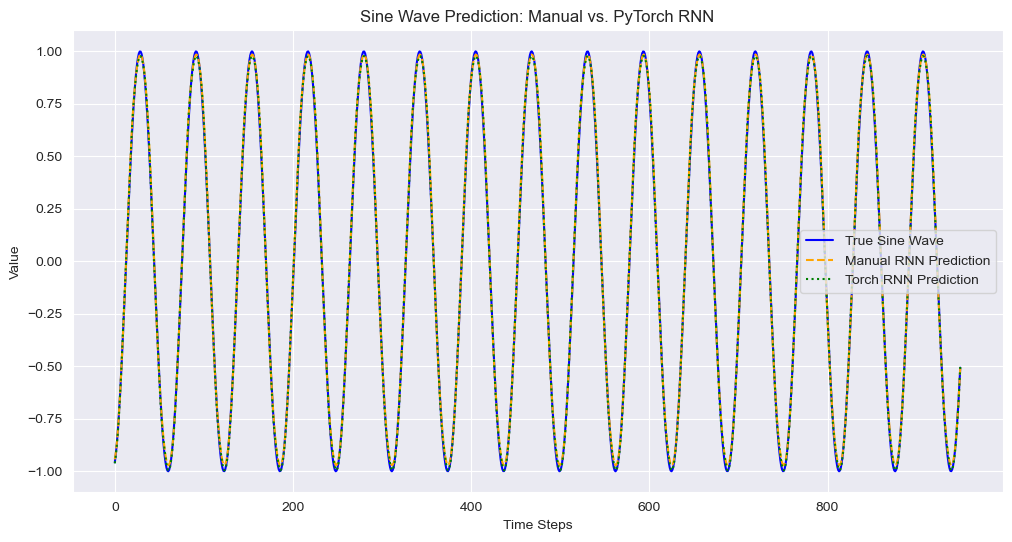

In [23]:
# Plotting results
pred_manual = []
pred_torch = []

with torch.no_grad():
    for i in range(X.size(0)):
        pred_manual.append(manual_model.forward(X[i]).detach().numpy()[-1])
        pred_torch.append(torch_model(X[i].unsqueeze(0)).detach().numpy())

pred_manual = np.array(pred_manual).flatten()
pred_torch = np.array(pred_torch).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y[seq_length:], label='True Sine Wave', color='blue')
plt.plot(pred_manual, label='Manual RNN Prediction', color='orange', linestyle='dashed')
plt.plot(pred_torch, label='Torch RNN Prediction', color='green', linestyle='dotted')
plt.legend()
plt.title('Sine Wave Prediction: Manual vs. PyTorch RNN')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()

### Example 2, variable frequency signal prediction
#### Creating Dataset and define model parameters
The result of mixing signals with different frequencies have a more complicated pattern than a sine wave, so a larger input sequence is needed or more hidden units on the hidden layer (larger size of the hidden layer).

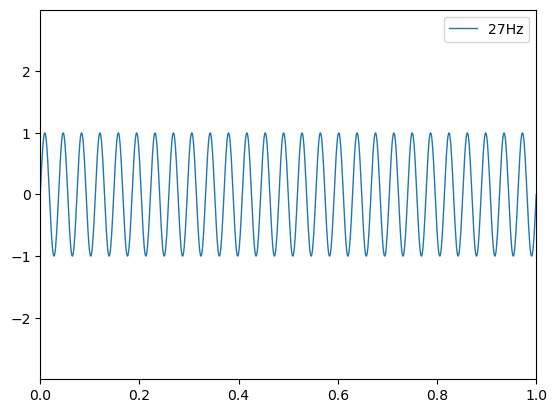

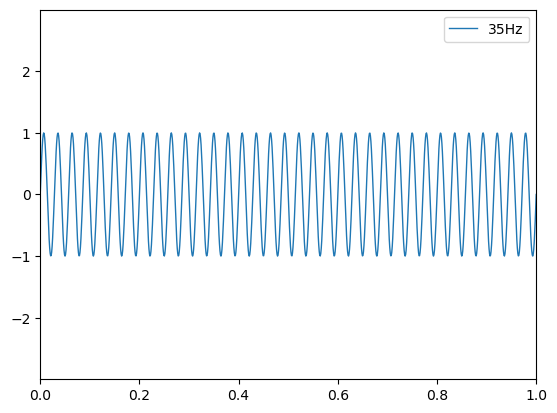

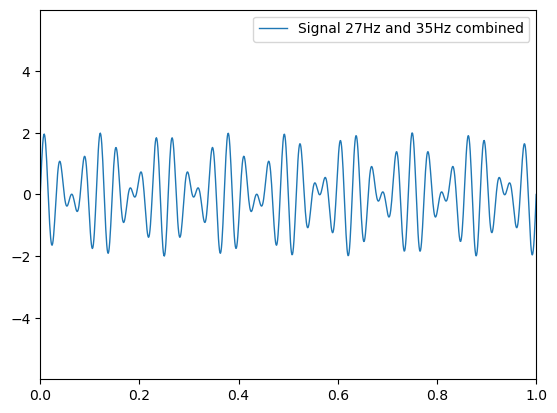

In [16]:
# Parameters for the signal frequencies and the amount of steps
signFreq1     = 27 #Hz
signFreq2     = 35 #Hz
steps         = 1000
range_start   = 0
range_end     = 1

npTime        = np.linspace(range_start,range_end,steps)
npSin1        = np.sin(2*np.pi*signFreq1*npTime)
npSin2        = np.sin(2*np.pi*signFreq2*npTime)
cleanSignal   = npSin1 + npSin2

## Sine frequency 1
plt.plot(npTime,npSin1,linewidth=1,label=str(signFreq1)+"Hz")
plt.margins(x=0, y=1)
plt.legend()
plt.show()

## Sine frequency 2
plt.plot(npTime,npSin2,linewidth=1,label=str(signFreq2)+"Hz")
plt.margins(x=0, y=1)
plt.legend()
plt.show()

## Combined signal, clean
plt.plot(npTime,cleanSignal,linewidth=1,label="Signal "+str(signFreq1)+"Hz and "+str(signFreq2) + "Hz combined")
plt.margins(x=0, y=1)
plt.legend()
plt.show()

In [17]:
# Parameters for signal model
seq_length = 50  # Length of input sequence (those are the number of "time steps")
input_size = 1   # Since we're predicting sine values, one feature
hidden_size = 34 # Size of hidden layer
output_size = 1  # Predicting a single value (sine wave)

# combined signal 
x = npTime
y = cleanSignal

X, Y = create_dataset(y, seq_length)

# reshaping for pytorch rnn layer
X = torch.tensor(X, dtype=torch.float32).view(-1, seq_length, input_size)

# one predicted value for each input sequence
Y = torch.tensor(Y, dtype=torch.float32).view(-1, output_size)

### Defining the model

In [18]:
# Compare with torch.nn.Module
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) #<- the tanh activation function is used by default for the hidden updates.
        out = self.fc(out[:, -1, :])  # Use the last hidden state
        return out

### Training loop

In [19]:
lr_2 = 0.0001
epochs_2 = 100
# Initialize and train RNN model
torch_model = RNNModel()
optimizer = optim.Adam(torch_model.parameters(), lr=lr_2)

# Training loop for torch.nn.Module
for epoch in range(epochs_2):
    for i in range(X.size(0)):
        x_t = X[i].unsqueeze(0)  # Add batch dimension
        y_t = Y[i]
        
        # Forward pass
        outputs = torch_model(x_t)
        loss = nn.MSELoss()(outputs, y_t.unsqueeze(0))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.27827414870262146
Epoch 5, Loss: 0.003080513095483184
Epoch 10, Loss: 0.00022917799651622772
Epoch 15, Loss: 0.001869679195806384
Epoch 20, Loss: 0.0018706773407757282
Epoch 25, Loss: 0.0012422478757798672
Epoch 30, Loss: 0.0017675613053143024
Epoch 35, Loss: 0.0013322113081812859
Epoch 40, Loss: 0.00036368818837217987
Epoch 45, Loss: 0.0011060875840485096
Epoch 50, Loss: 0.0012870482169091702
Epoch 55, Loss: 0.0001082713934010826
Epoch 60, Loss: 4.912064355266921e-07
Epoch 65, Loss: 4.647101832233602e-06
Epoch 70, Loss: 0.0003797141835093498
Epoch 75, Loss: 4.5700437567575136e-07
Epoch 80, Loss: 0.00036722104414366186
Epoch 85, Loss: 0.00020587323524523526
Epoch 90, Loss: 8.502812124788761e-05
Epoch 95, Loss: 2.41879979512305e-06


### Plotting the results

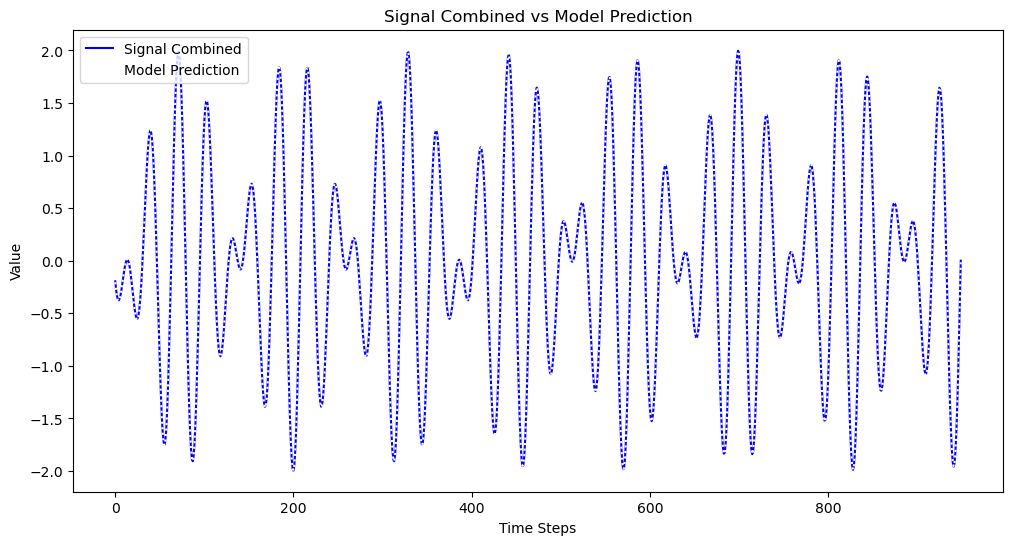

In [21]:
# Plotting results
pred_torch = []

with torch.no_grad():
    for i in range(X.size(0)):
        pred_torch.append(torch_model(X[i].unsqueeze(0)).detach().numpy())

pred_torch = np.array(pred_torch).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y[seq_length:], label='Signal Combined', color='blue')
plt.plot(pred_torch, label='Model Prediction', color='white', linestyle='dotted')
plt.legend()
plt.title('Signal Combined vs Model Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()